<a href="https://colab.research.google.com/github/aim56009/AI-MA_project/blob/main/Masterproject_final_tensor_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 

In [ ]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import torchvision.transforms.functional as TF 

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import os
import random
import click
import sklearn
import sklearn.model_selection
from collections import defaultdict
from sklearn.metrics import accuracy_score
from pathlib import Path
import sys
from torch import optim
from torch.optim import lr_scheduler
from functools import partial
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/aim56009/AI-MA_project.git

fatal: destination path 'AI-MA_project' already exists and is not an empty directory.


# Dataloader

In [ ]:
batch_size = 1 
PATH_TO_DATA = "AI-MA_project/bach_pr_fugues"
workers = 0

In [ ]:
class MusicDataset(Dataset):

    def __init__(self, data_dir, transforms=None):
        self.transforms = transforms
        self.data_dir = data_dir

        labels = ["voice_0", "voice_1", "voice_2", "voice_3", "voice_all"]
        self.labels = labels
        self.pr_dict = {}
        len_list = []

        for iLabel in range(len(labels)):
            
            if iLabel == 4:   
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl")))   
                for name in file_names:
                    with open(name ,'rb') as f: ### normal sollte es egal sein wenn voice_4 bei manchen nicht existiert - wenn nicht condition einführen damit das funktioniert
                        loaded_obj = pickle.load(f)  
                        voice_files.append(loaded_obj) 
                        len_list.append(len(loaded_obj.T))
                        
                self.pr_dict[self.labels[iLabel]] = voice_files 
                self.pr_dict["length"] = len_list

            
            else:
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl"))) 
                for name in file_names:
                    with open(name ,'rb') as f: 
                        loaded_obj = pickle.load(f)     
                        voice_files.append(loaded_obj)

                self.pr_dict[self.labels[iLabel]] = voice_files 


    def __len__(self):
      
        return len(self.pr_dict[self.labels[0]])

    def __getitem__(self, idx):          

        out_list = []
        for key, value in self.pr_dict.items():
            out_list.append(self.pr_dict[key][idx])    

        v0 = torch.tensor(out_list[0].T)
        v1 = torch.tensor(out_list[1].T)
        v2 = torch.tensor(out_list[2].T)
        v3 = torch.tensor(out_list[3].T)
        v_all = torch.tensor(out_list[4].T) 
        length = self.pr_dict["length"][idx]


        return (v0, v1, v2, v3, v_all, length)

In [ ]:
class MusicDataset_new(Dataset):

    def __init__(self, data_dir, transforms=None):
        self.transforms = transforms
        self.data_dir = data_dir

        self.name_list = ["1f01","1f02","1f03","1f04","1f05","1f06","1f07","1f08","1f09","1f10","1f11","1f12","1f13","1f14","1f15","1f16","1f17","1f18","1f19","1f20","1f21","1f22","1f23","1f24","2f01","2f02","2f03","2f04","2f05","2f06","2f07","2f08","2f09","2f10","2f11","2f12","2f13","2f14","2f15","2f16","2f17","2f18","2f19","2f20","2f21","2f22","2f23","2f24"]
        self.name_list_voice_3 =  ['1f01', '1f05', '1f12', '1f14', '1f16', '1f17', '1f18', '1f23', '1f24', '2f02', '2f05', '2f07', '2f08', '2f09', '2f16', '2f17',  '2f22', '2f23']
        labels = ["voice_0", "voice_1", "voice_2", "voice_3", "voice_all"]
        self.labels = labels
        self.pr_dict = {}
        len_list = []
        nbr_voices_list = []

        for iLabel in range(len(labels)):
            
            if iLabel == 4:   
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl")))   
                for name in file_names:
                    with open(name ,'rb') as f: ### normal sollte es egal sein wenn voice_4 bei manchen nicht existiert - wenn nicht condition einführen damit das funktioniert
                        loaded_obj = pickle.load(f)  
                        voice_files.append(loaded_obj) 
                        len_list.append(len(loaded_obj.T))
                    if "AI-MA_project/bach_pr_fugues/voice_3/voice_3_" + name[49:53] + ".pkl" in sorted(glob.glob(os.path.join(PATH_TO_DATA, "voice_3", "*.pkl"))):
                        nbr_voices_list.append(4)
                    else:
                        nbr_voices_list.append(3)
                        
                self.pr_dict[self.labels[iLabel]] = voice_files 
                self.pr_dict["length"] = len_list
                self.pr_dict["nbr_voices"] = nbr_voices_list

            if iLabel == 3:  
                voice_files = []
                file_names_3 = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl"))) 
                file_names_2 = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[2], "*.pkl")))   
                
                ###### loop over all filnames in voices_2 and if an element there is not present in voices_3: append "missing" to the voice_files of label=3 => important bc. self.pr_dict[voice_3] has then len 42 and otherwise it would only have len 18  .. these "missing" el are not considered later in the dataloader (if len=3 is a diff case of get_idx)
                for name in file_names_2:
                    if name[45:49] in self.name_list_voice_3:
                      correct_name_3 = "AI-MA_project/bach_pr_fugues/voice_3/voice_3_" + name[45:49] + ".pkl"
                      with open(correct_name_3 ,'rb') as f:  
                            loaded_obj = pickle.load(f)  
                            voice_files.append(loaded_obj)
                    else:
                      voice_files.append("missing")

                self.pr_dict[self.labels[iLabel]] = voice_files 

                
            else:
                voice_files = []
                file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, self.labels[iLabel], "*.pkl"))) 
                for name in file_names:
                    with open(name ,'rb') as f: 
                          loaded_obj = pickle.load(f)     
                          voice_files.append(loaded_obj)

                self.pr_dict[self.labels[iLabel]] = voice_files 


    def __len__(self):
        return len(self.pr_dict[self.labels[0]])

    def __getitem__(self, idx):      
        out_list = []
        
        if self.pr_dict["nbr_voices"][idx] == 4:
            for key, value in self.pr_dict.items():
              out_list.append(self.pr_dict[key][idx])
                              
            v0 = torch.tensor(out_list[0].T)
            v1 = torch.tensor(out_list[1].T)
            v2 = torch.tensor(out_list[2].T)
            v3 = torch.tensor(out_list[3].T)
            v_all = torch.tensor(out_list[4].T) 
            length = self.pr_dict["length"][idx]
            nbr_voices = self.pr_dict["nbr_voices"][idx]

            return (v0, v1, v2, v3, v_all, length, nbr_voices)
        
        if self.pr_dict["nbr_voices"][idx] == 3:

            for key, value in self.pr_dict.items():
                if key != "voice_3":
                  out_list.append(self.pr_dict[key][idx]) 
            
            v0 = torch.tensor(out_list[0].T)
            v1 = torch.tensor(out_list[1].T)
            v2 = torch.tensor(out_list[2].T)
            v_all = torch.tensor(out_list[3].T) 
            length = self.pr_dict["length"][idx]
            nbr_voices = self.pr_dict["nbr_voices"][idx]

            return (v0, v1, v2, True , v_all, length, nbr_voices)
        

In [ ]:
#dataset = MusicDataset(PATH_TO_DATA)
dataset = MusicDataset_new(PATH_TO_DATA)
loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

In [ ]:
for i, sample_batched in enumerate(loader):
    v0, v1, v2, v3, v_all, length, nbr_voices = sample_batched
    if nbr_voices ==3:
      print(i,nbr_voices,v3)
    else:
      print(i,nbr_voices)

0 tensor([4])
1 tensor([3]) tensor([True])
2 tensor([4])
3 tensor([3]) tensor([True])
4 tensor([3]) tensor([True])
5 tensor([3]) tensor([True])
6 tensor([3]) tensor([True])
7 tensor([3]) tensor([True])
8 tensor([4])
9 tensor([3]) tensor([True])
10 tensor([4])
11 tensor([4])
12 tensor([4])
13 tensor([4])
14 tensor([3]) tensor([True])
15 tensor([3]) tensor([True])
16 tensor([4])
17 tensor([4])
18 tensor([3]) tensor([True])
19 tensor([4])
20 tensor([3]) tensor([True])
21 tensor([3]) tensor([True])
22 tensor([4])
23 tensor([3]) tensor([True])
24 tensor([4])
25 tensor([4])
26 tensor([4])
27 tensor([3]) tensor([True])
28 tensor([3]) tensor([True])
29 tensor([3]) tensor([True])
30 tensor([3]) tensor([True])
31 tensor([3]) tensor([True])
32 tensor([4])
33 tensor([4])
34 tensor([3]) tensor([True])
35 tensor([3]) tensor([True])
36 tensor([3]) tensor([True])
37 tensor([3]) tensor([True])
38 tensor([4])
39 tensor([4])
40 tensor([3]) tensor([True])


In [ ]:
for i, sample_batched in enumerate(loader):
  if i ==1:
    v0, v1, v2, v3, v_all, length, nbr_voices = sample_batched
    print(i,nbr_voices,v3)


1 tensor([3]) tensor([True])


# Define Music - Model


Define UNET 

In [ ]:
class UNET(nn.Module):
    
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        self.double_conv_downs = nn.ModuleList([self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList([nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2) for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList([self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
        
        concat_layers = concat_layers[::-1]
        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x 

In [ ]:
class MusicNetwork(nn.Module):

    def __init__(self, network_type,output_dim=128, hidden_dim=300, rnn_depth=1, cell_type="GRU"):                 
        super(MusicNetwork, self).__init__()

        self.network_type = network_type
        self.n_out = output_dim
        input_dim = output_dim 
        rnn_cell = nn.GRU
        self.rnn = rnn_cell(input_size=input_dim, hidden_size=hidden_dim, num_layers=rnn_depth, batch_first=True)
        self.cnn = UNET(in_channels=1, classes=4)
        self.top_layer_voice_0 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_1 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_2 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_3 = nn.Linear(hidden_dim, self.n_out)
        self.loss = nn.CrossEntropyLoss(reduction="mean")

    def compute_outputs(self, sentences, sentences_len):
        if self.network_type == "RNN":
          rnn_out ,_= self.rnn(sentences)
          
          out_0 = self.top_layer_voice_0(rnn_out)
          out_1 = self.top_layer_voice_1(rnn_out)
          out_2 = self.top_layer_voice_2(rnn_out)
          out_3 = self.top_layer_voice_3(rnn_out)

        

        else: 
          sentences = sentences[:,None]
          out = self.cnn(sentences)
          out_0 = out[:,0,:]
          out_1 = out[:,1,:]
          out_2 = out[:,2,:]
          out_3 = out[:,3,:]


        return out_0, out_1, out_2, out_3

    def forward(self, sentences, v0, v1, v2, v3, sentences_len, nbr_voices):            

        if nbr_voices==4:
            # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
            scores_0, scores_1, scores_2, scores_3 = self.compute_outputs(sentences, sentences_len)

            # Flatten the outputs and the labels, to compute the loss.
            # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
            score_0  = scores_0.view(-1, self.n_out)
            score_1  = scores_1.view(-1, self.n_out)
            score_2  = scores_2.view(-1, self.n_out)
            score_3  = scores_3.view(-1, self.n_out)

            v0 = v0.squeeze()
            v1 = v1.squeeze()
            v2 = v2.squeeze()
            v3 = v3.squeeze()
         
            loss = self.loss(score_0, v0) + self.loss(score_1, v1) + self.loss(score_2, v2) + self.loss(score_3, v3)            
            
            return loss
        
        else:
            # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
            scores_0, scores_1, scores_2, scores_3 = self.compute_outputs(sentences, sentences_len)

            # Flatten the outputs and the labels, to compute the loss.
            # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
            score_0  = scores_0.view(-1, self.n_out)
            score_1  = scores_1.view(-1, self.n_out)
            score_2  = scores_2.view(-1, self.n_out)

            v0 = v0.squeeze()
            v1 = v1.squeeze()
            v2 = v2.squeeze()
           
            loss = self.loss(score_0, v0) + self.loss(score_1, v1) + self.loss(score_2, v2) 
            
            return loss

    def predict(self, sentences, sentences_len,monophonic=True):

        # Compute the outputs from the linear units.
        scores_0, scores_1, scores_2, scores_3 = self.compute_outputs(sentences, sentences_len)

        if monophonic==False:
            sum_0 = scores_0 * sentences
            sum_1 = scores_1 * sentences
            sum_2 = scores_2 * sentences
            sum_3 = scores_3 * sentences

            return np.squeeze(sum_0.cpu().numpy()), np.squeeze(sum_1.cpu().numpy()), np.squeeze(sum_2.cpu().numpy()), np.squeeze(sum_3.cpu().numpy())

        else:
            # Select the top-scoring labels. The shape is now (max_len, n_sentences).
            predicted_0 = scores_0.argmax(dim=2)
            predicted_1 = scores_1.argmax(dim=2)
            predicted_2 = scores_2.argmax(dim=2)
            predicted_3 = scores_3.argmax(dim=2)       

            return np.squeeze(predicted_0.cpu().numpy()), np.squeeze(predicted_1.cpu().numpy()), np.squeeze(predicted_2.cpu().numpy()), np.squeeze(predicted_3.cpu().numpy())

# Define Training Process

In [ ]:
def train(epochs, lr, hidden_dim, momentum, rnn_depth, device, rnn_cell, weight_decay,network_type, train_dataloader, val_dataloader=None):
    
    output_dim = 88
    model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)              
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.MultiStepLR(optimizer, [epochs // 2], gamma=0.1, verbose=True)

    history = training_loop(model, optimizer, train_dataloader,monophonic, epochs=epochs, val_dataloader=val_dataloader, device=device, scheduler=scheduler)

    return model, history

In [ ]:
def training_loop(model,optimizer, train_dataloader, monophonic, epochs=50, val_dataloader=None, device=None, scheduler=None):
    if device is None:
        device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        print(f"Training on device: {device}")

    print("monophonic set to:",monophonic)
    model = model.to(device)
    history = defaultdict(list)

    for i_epoch in range(1, epochs + 1):
        loss_sum = 0
        accuracy_v0_sum = 0
        accuracy_v1_sum = 0
        accuracy_v2_sum = 0
        accuracy_v3_sum = 0
        accuracy_v_all_sum = 0
        model.train()
        accuracy_sum = 0
        

        for idx, (v0, v1, v2, v3, v_all, lens, nbr_voices) in enumerate(train_dataloader):  
            
            v0, v1, v2, v3, v_all = (v0.to(device).float(), v1.to(device).float(), v2.to(device).float(), v3.to(device).float(), v_all.to(device).float())
          
            optimizer.zero_grad()
            loss = model.forward(v_all, v0, v1, v2, v3, lens, nbr_voices)

            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            

            if monophonic == False:
                with torch.no_grad():
                    pred_v0, pred_v1, pred_v2, pred_v3 = model.predict(v_all, lens, monophonic)

                    if nbr_voices == 4: 
                        v_pred_comb = torch.stack([torch.tensor(pred_v0), torch.tensor(pred_v1), torch.tensor(pred_v2), torch.tensor(pred_v3)], dim=2)
                    if nbr_voices ==3:
                        v_pred_comb = torch.stack([torch.tensor(pred_v0), torch.tensor(pred_v1), torch.tensor(pred_v2)], dim=2)
                    v_pred_argm = v_pred_comb.argmax(dim=2)
                    mask_pred = (v_pred_comb.sum(axis=2) == 0).numpy()
                    v_pred_argm[mask_pred] = -1
                    v_pred_flat = torch.flatten(v_pred_argm, start_dim=0, end_dim=-1)

                    if nbr_voices == 4:                   
                        v_ori_comb = torch.stack([np.squeeze(v0).cpu(), np.squeeze(v1).cpu(), np.squeeze(v2).cpu(), np.squeeze(v3).cpu()], dim=2)
                    if nbr_voices ==3:
                        v_ori_comb = torch.stack([np.squeeze(v0).cpu(), np.squeeze(v1).cpu(), np.squeeze(v2).cpu()], dim=2)
                    v_ori_argm = v_ori_comb.argmax(dim=2)
                    mask_ori = (v_ori_comb.sum(axis=2) == 0).numpy()
                    v_ori_argm[mask_ori] = -1
                    v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)
                    acc = accuracy_score(v_pred_flat,v_ori_flat)                       
                    accuracy_sum += acc 


            if monophonic == True:
                with torch.no_grad():
                    pred_v0, pred_v1, pred_v2, pred_v3 = model.predict(v_all, lens,monophonic)

                    acc_v0 = accuracy_score(torch.tensor(pred_v0), np.squeeze(v0).argmax(dim=1).cpu())
                    acc_v1 = accuracy_score(torch.tensor(pred_v1), np.squeeze(v1).argmax(dim=1).cpu())
                    acc_v2 = accuracy_score(torch.tensor(pred_v2), np.squeeze(v2).argmax(dim=1).cpu())
                    if nbr_voices == 4:
                        acc_v3 = accuracy_score(torch.tensor(pred_v3), np.squeeze(v3).argmax(dim=1).cpu())
                    
                    # normalize according to the number of sequences in the batch (atm len(lens)==1)
                    accuracy_v0_sum += acc_v0 / len(lens)
                    accuracy_v1_sum += acc_v1 / len(lens)
                    accuracy_v2_sum += acc_v2 / len(lens)
                    if nbr_voices == 4:
                        accuracy_v3_sum += acc_v3 / len(lens)


        train_loss = loss_sum / len(train_dataloader)

        # normalize according to the number of batches
        if monophonic == True:
            train_accuracy_v0 = accuracy_v0_sum / len(train_dataloader)
            train_accuracy_v1 = accuracy_v1_sum / len(train_dataloader)
            train_accuracy_v2 = accuracy_v2_sum / len(train_dataloader)
            train_accuracy_v3 = accuracy_v3_sum / 18   ## bc only 18 pieces with len 3

            history["train_loss"].append(train_loss)
            history["train_accuracy_v0"].append(train_accuracy_v0)
            history["train_accuracy_v1"].append(train_accuracy_v1)
            history["train_accuracy_v2"].append(train_accuracy_v2)
            #if nbr_voices == 4:
            history["train_accuracy_v3"].append(train_accuracy_v3)
            print("Train Loss: {}, Train Accuracy_0 : {}, Train Accuracy_1 : {},Train Accuracy_2 : {}, Train Accuracy_3 : {}".format(train_loss, train_accuracy_v0, train_accuracy_v1, train_accuracy_v2, train_accuracy_v3)) 
            #else:
            #    print("Train Loss: {}, Train Accuracy_0 : {}, Train Accuracy_1 : {},Train Accuracy_2 : {}".format(train_loss, train_accuracy_v0, train_accuracy_v1, train_accuracy_v2)) 

        if monophonic == False:
            train_accuracy = accuracy_sum / len(train_dataloader)

            history["train_loss"].append(train_loss)
            history["train_accuracy"].append(train_accuracy)
            print("Train Loss: {}, Train Accuracy : {}".format(train_loss, train_accuracy)) 


        if monophonic == True:
            if val_dataloader is not None:
                # Evaluate on the validation set
                model.eval()
                accuracy_v0_sum = 0
                accuracy_v1_sum = 0
                accuracy_v2_sum = 0
                accuracy_v3_sum = 0

                with torch.no_grad():

                    for v0, v1, v2, v3, v_all, lens, nbr_voices in val_dataloader:

                        v0, v1, v2, v3, v_all = (v0.to(device).float(), v1.to(device).float(), v2.to(device).float(), v3.to(device).float(), v_all.to(device).float())

                        # Predict the model's output on a batch
                        pred_v0, pred_v1, pred_v2, pred_v3 = model.predict(v_all, lens,monophonic)
                            
                        # compute the accuracy 
                        acc_v0 = accuracy_score(torch.tensor(pred_v0), np.squeeze(v0).argmax(dim=1).cpu())
                        acc_v1 = accuracy_score(torch.tensor(pred_v1), np.squeeze(v1).argmax(dim=1).cpu())
                        acc_v2 = accuracy_score(torch.tensor(pred_v2), np.squeeze(v2).argmax(dim=1).cpu())
                        if nbr_voices == 4:
                            acc_v3 = accuracy_score(torch.tensor(pred_v3), np.squeeze(v3).argmax(dim=1).cpu())
                            
                            
                        # normalize according to the number of sequences in the batch (atm len(lens)==1)
                        accuracy_v0_sum += acc_v0 / len(lens)
                        accuracy_v1_sum += acc_v1 / len(lens)
                        accuracy_v2_sum += acc_v2 / len(lens)
                        if nbr_voices == 4:
                            accuracy_v3_sum += acc_v3 / len(lens)

                    # normalize according to the number of batches
                    val_accuracy_v0 = accuracy_v0_sum / len(val_dataloader)
                    val_accuracy_v1 = accuracy_v1_sum / len(val_dataloader)
                    val_accuracy_v2 = accuracy_v2_sum / len(val_dataloader)
                    val_accuracy_v3 = accuracy_v3_sum / 18  ##len(val_dataloader). - bc 18 pieces only with voice 3

                history["val_accuracy_v0"].append(val_accuracy_v0)
                history["val_accuracy_v1"].append(val_accuracy_v1)
                history["val_accuracy_v2"].append(val_accuracy_v2)
                #if nbr_voices == 4:
                history["val_accuracy_v3"].append(val_accuracy_v3)
                print(" Validation Accuracy_0 : {}, Validation Accuracy_1 : {}, Validation Accuracy_2 : {}, Validation Accuracy_3 : {}".format(val_accuracy_v0, val_accuracy_v1, val_accuracy_v2, val_accuracy_v3))
                #else:
                #    print(" Validation Accuracy_0 : {}, Validation Accuracy_1 : {}, Validation Accuracy_2 : {}".format(val_accuracy_v0, val_accuracy_v1, val_accuracy_v2))



        if monophonic == False:
            if val_dataloader is not None:
                # Evaluate on the validation set
                model.eval()
                accuracy_sum = 0
                
                with torch.no_grad():
                    for v0, v1, v2, v3, v_all, lens, nbr_voices in val_dataloader:

                        v0, v1, v2, v3, v_all = (v0.to(device).float(), v1.to(device).float(), v2.to(device).float(), v3.to(device).float(), v_all.to(device).float())

                        # Predict the model's output on a batch
                        pred_v0, pred_v1, pred_v2, pred_v3 = model.predict(v_all, lens,monophonic)
                        
                        if nbr_voices == 4: 
                            v_pred_comb = torch.stack([torch.tensor(pred_v0), torch.tensor(pred_v1), torch.tensor(pred_v2), torch.tensor(pred_v3)], dim=2)
                        if nbr_voices ==3:
                            v_pred_comb = torch.stack([torch.tensor(pred_v0), torch.tensor(pred_v1), torch.tensor(pred_v2)], dim=2)
                        v_pred_argm = v_pred_comb.argmax(dim=2)
                        mask_pred = (v_pred_comb.sum(axis=2) == 0).numpy()
                        v_pred_argm[mask_pred] = -1
                        v_pred_flat = torch.flatten(v_pred_argm, start_dim=0, end_dim=-1)                      
                        if nbr_voices == 4:                   
                            v_ori_comb = torch.stack([np.squeeze(v0).cpu(), np.squeeze(v1).cpu(), np.squeeze(v2).cpu(), np.squeeze(v3).cpu()], dim=2)
                        if nbr_voices ==3:
                            v_ori_comb = torch.stack([np.squeeze(v0).cpu(), np.squeeze(v1).cpu(), np.squeeze(v2).cpu()], dim=2)
                        v_ori_argm = v_ori_comb.argmax(dim=2)
                        mask_ori = (v_ori_comb.sum(axis=2) == 0).numpy()
                        v_ori_argm[mask_ori] = -1
                        v_ori_flat = torch.flatten(v_ori_argm, start_dim=0, end_dim=-1)

                        acc = accuracy_score(v_pred_flat,v_ori_flat)
                        accuracy_sum += acc 
                        
                    # normalize according to the number of batches
                    val_accuracy = accuracy_sum / len(val_dataloader)

                history["val_accuracy"].append(val_accuracy)  
                print(" Validation Accuracy : {}".format(val_accuracy))


        if scheduler is not None:
            scheduler.step()

        # save the model
        torch.save(model, Path("./AI-MA_project/model_temp_epoch{}.pkl".format(i_epoch)))

    return history

In [ ]:
"""
network_type= ["CNN","RNN"]
monophonic_list = [True,False]

for net in network_type:
    for monophonic in monophonic_list: 
        print("network set to:",net,"monophnic:",monophonic)
        start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, net, learn_all)
"""

'\nnetwork_type= ["CNN","RNN"]\nmonophonic_list = [True,False]\n\nfor net in network_type:\n    for monophonic in monophonic_list: \n        print("network set to:",net,"monophnic:",monophonic)\n        start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, net, learn_all)\n'

In [ ]:
def start_experiment( epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell, decay,network_type, learn_all):
    
    trainer = partial(train,epochs, lr, hidden_dim, momentum, rnn_depth, device, cell, decay, network_type)

    if learn_all == True:
        print("Learning from full dataset")
        train_dataset = MusicDataset_new(PATH_TO_DATA) #MusicDataset(PATH_TO_DATA)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
                
        _, history = trainer(train_dataloader)

    
    else:
        # Divide train and validation set
        path_train, path_validation = sklearn.model_selection.train_test_split(PATH_TO_DATA, test_size=0.15, random_state=10,)

        print("Train and validation lenghts: ", len(path_train), len(path_validation))
        train_dataset = MusicDataset_new(PATH_TO_DATA) #MusicDataset(PATH_TO_DATA)
        validation_dataset = MusicDataset_new(path_validation) #MusicDataset(path_validation)
        
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

        _, history = trainer(train_dataloader, val_dataloader)

    return history

# Hyperparameter choice

In [ ]:
model = MusicNetwork
epochs = 10
lr = 0.001  
momentum = 0.9
decay = 1e-4
hidden_dim = 300
bs = 1
rnn_depth = 2 
device = None                 #if None:  choses device automatically
cell_type = "GRU"
optimizer = "Adam"
learn_all = "False"           # False -> uses train + valid set
network_type= "RNN"

monophonic = False

# Run the Experiment

In [ ]:
his = start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)

Train and validation lenghts:  23 5
Adjusting learning rate of group 0 to 1.0000e-03.
Training on device: cuda
monophonic set to: False
Train Loss: 9.65258464580629, Train Accuracy : 0.9890450111134539
 Validation Accuracy : 0.9888822983897889
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 8.831065282589051, Train Accuracy : 0.9896555912646351
 Validation Accuracy : 0.9892654400632278
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 8.438701001609244, Train Accuracy : 0.989682210248745
 Validation Accuracy : 0.9896569870615279
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 7.127984837787907, Train Accuracy : 0.9898440930957713
 Validation Accuracy : 0.9897364672483149
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 5.26555964423389, Train Accuracy : 0.9900232025989312
 Validation Accuracy : 0.9899573558526927
Adjusting learning rate of group 0 to 1.0000e-04.
Train Loss: 4.128644367543663, Train Accuracy : 0.9901945110995165
 Vali

# Visualization

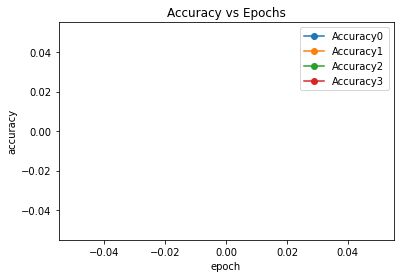

In [ ]:
plt.plot(his["val_accuracy_v0"],'-o')
plt.plot(his["val_accuracy_v1"],'-o')
plt.plot(his["val_accuracy_v2"],'-o')
plt.plot(his["val_accuracy_v3"],'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Accuracy0','Accuracy1','Accuracy2','Accuracy3'])
plt.title('Accuracy vs Epochs')

plt.show()

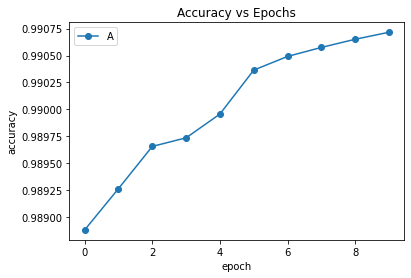

In [ ]:
plt.plot(his["val_accuracy"],'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend('Accuracy')
plt.title('Accuracy vs Epochs')

plt.show()

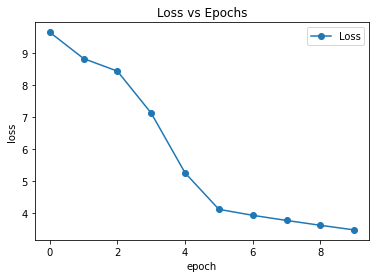

In [ ]:
plt.plot(his["train_loss"],'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss'])
plt.title('Loss vs Epochs')

plt.show()